# 1. Import Libraries

In [1]:
# data management libraries
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import os
import time

#always :)
style.use("dark_background") 

# 2. Read Data 

In [2]:
df = pd.read_csv('data/transactions.csv')
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
# check for missing values
df.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

# 3. EDA

**Features:** 
- **Step:**  
    Represents the day when the transaction happened. There is a total of 180 steps, so the data runs for six months. This field will be **dropped** since its non significant.
- **Customer:**  
    Represents the unique ID of the person who initialized the transaction. It is formed by the letter `C`, followed by a unique sequence of 10 numbers. There is a total of 4,109 unique customers available in the dataset, so this will also be dropped, since the algorithm shouldn't be biased against any customer id.
- **Age:**  
    This variable is split into age intervals, starting from 0 to 6, and the letter `U` which stands for Unknown. Age is Unknown only for transactions that have the gender equal to Enterprise. The coding for the numbers is:  
    - `0`: less than 18 years old  
    - `1`: between 19 and 25 years old  
    - `2`: between 26 and 35 years old  
    - `3`: between 36 and 45 years old  
    - `4`: between 46 and 55 years old  
    - `5`: between 56 and 65 years old  
    - `6`: older than 65 years old  
    - `7`: `U` will be mapped to `7` for numerical encoding purposes. 
- **Gender:**  
    This variable is coded as `F` for Female, `M` for Male, `E` for Enterprise, and `U` for Unknown. The Unknown group has around 170 customers aged in groups 1, 2, and 3. Unkown gender inputs will be dropped, because they are considered as incomplete entries.
- **Merchant:**  
    Represents the unique ID of the party which receives the transaction. Similar to customer ID, the sequence is formed by the letter `M`, followed by a series of 9 numbers. There is a total of 50 unique merchants in the dataset. This column will also be dropped, since the algorithm shouldn't be biased based on merchant id either.
- **Category:**  
    There are 15 unique categories that label the general type of the transaction:  
    `transportation`, `food`, `health`, `wellness and beauty`, `fashion`, `bars and restaurant`, `hyper`, `sports and toys`, `tech`, `home`, `hotel services`, `other services`, `contents`, `travel`, `leisure`.  
- **Amount:**  
    Represents the value of the transaction. There are only 52 values equal to 0 and no negative values.  
- **Fraud:**  
    A flag column coded with `0` if the transaction was clean and with `1` if the transaction was fraudulent.  
- **zipcodeOri** and **zipMerchant:**  
    These two features will be **removed** from the dataset, as they contained a constant value of `28007`, which is a postal code in Ansonville, North Carolina, United States. 

### Preprosessing

In [4]:
# drop the columns that are not significant for clustering
df = df.drop(columns=['step', 'customer', 'merchant', 'zipcodeOri', 'zipMerchant'])

#remove 'es_' from the 'category' column
df['category'] = df['category'].str.replace('es_', '', regex=False)

# remove special symbols from all columns
df = df.replace("^.|.$", '', regex=False)

#drop rows that have 'U' in 'gender' column
df = df[df['gender'] != '\'U\'']

# replace 'U' with '7' in age and convert age from str to int
df['age'] = df['age'].replace('\'U\'', '7').str.strip("'\"").astype(int)

# encode the gender/category columns using one-hot encoding keep the original columns
gender = df['gender']
category = df['category']
df = pd.get_dummies(df, columns=['gender', 'category'])
df['gender_original'] = gender
df['category_original'] = category

In [5]:
df.head()

,age,amount,fraud,gender_'E',gender_'F',gender_'M',category_'barsandrestaurants',category_'contents',category_'fashion',category_'food',...,category_'hyper',category_'leisure',category_'otherservices',category_'sportsandtoys',category_'tech',category_'transportation',category_'travel',category_'wellnessandbeauty',gender_original,category_original
0,4,4.55,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
1,2,39.68,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
2,4,26.89,0,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,'F','transportation'
3,3,17.25,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
4,5,35.72,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'


### Plotting

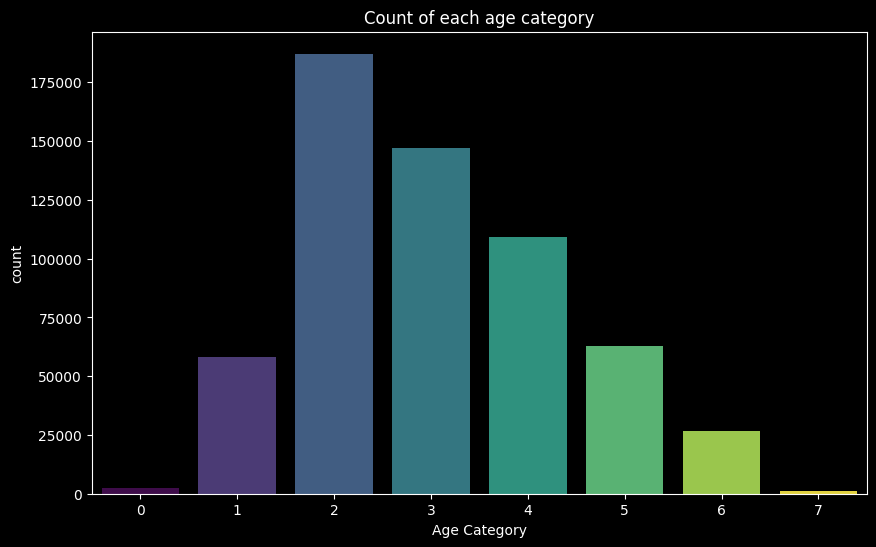

In [6]:
#plot count of each age category
plt.figure(figsize=(10, 6));
sns.countplot(data=df, x='age', hue='age', palette='viridis', legend=False);
plt.title('Count of each age category')
plt.xlabel('Age Category')
plt.show()

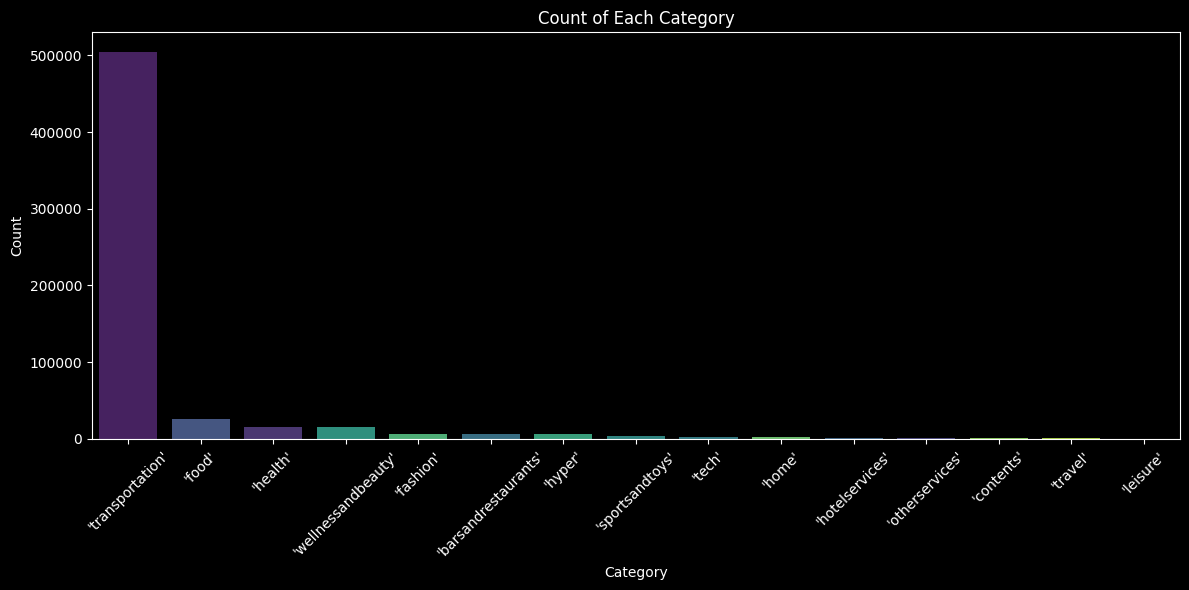

In [7]:
#plot count of each category
plt.figure(figsize=(12, 6))
sns.countplot(data=df, 
    x='category_original', 
    hue='category_original', 
    order=df['category_original'].value_counts().index, 
    palette='viridis', 
    dodge=False)
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Count of Each Category')
plt.tight_layout()
plt.show()

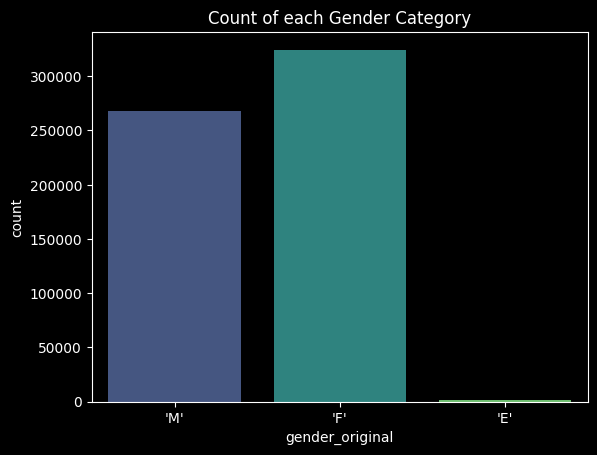

In [8]:
#plot count of each gender
sns.countplot(data=df, x='gender_original', hue='gender_original', palette='viridis', legend=False);
plt.title('Count of each Gender Category')
plt.show()

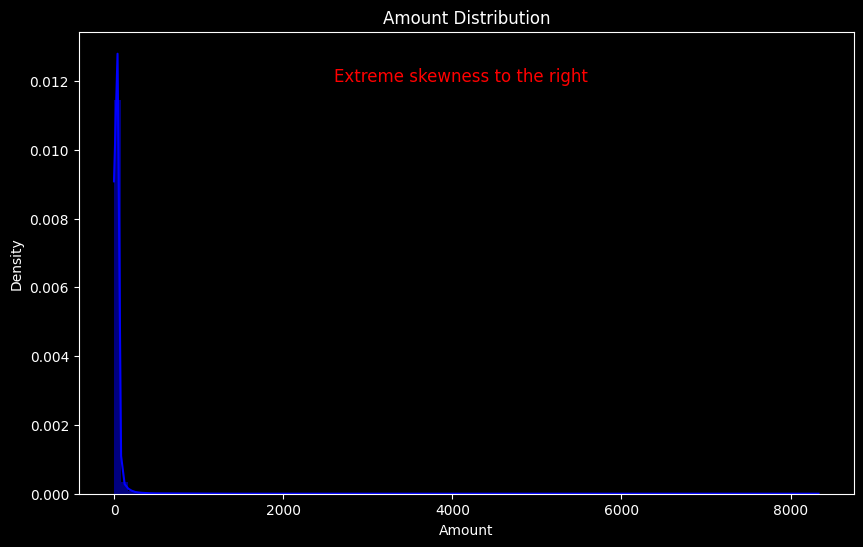

In [9]:
# plot the amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(x=df['amount'], kde=True, color='blue', bins=100, stat='density', linewidth=0, alpha=0.5)
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.text(x=2600, y=0.012, s='Extreme skewness to the right', fontsize=12, color='red')
plt.show()

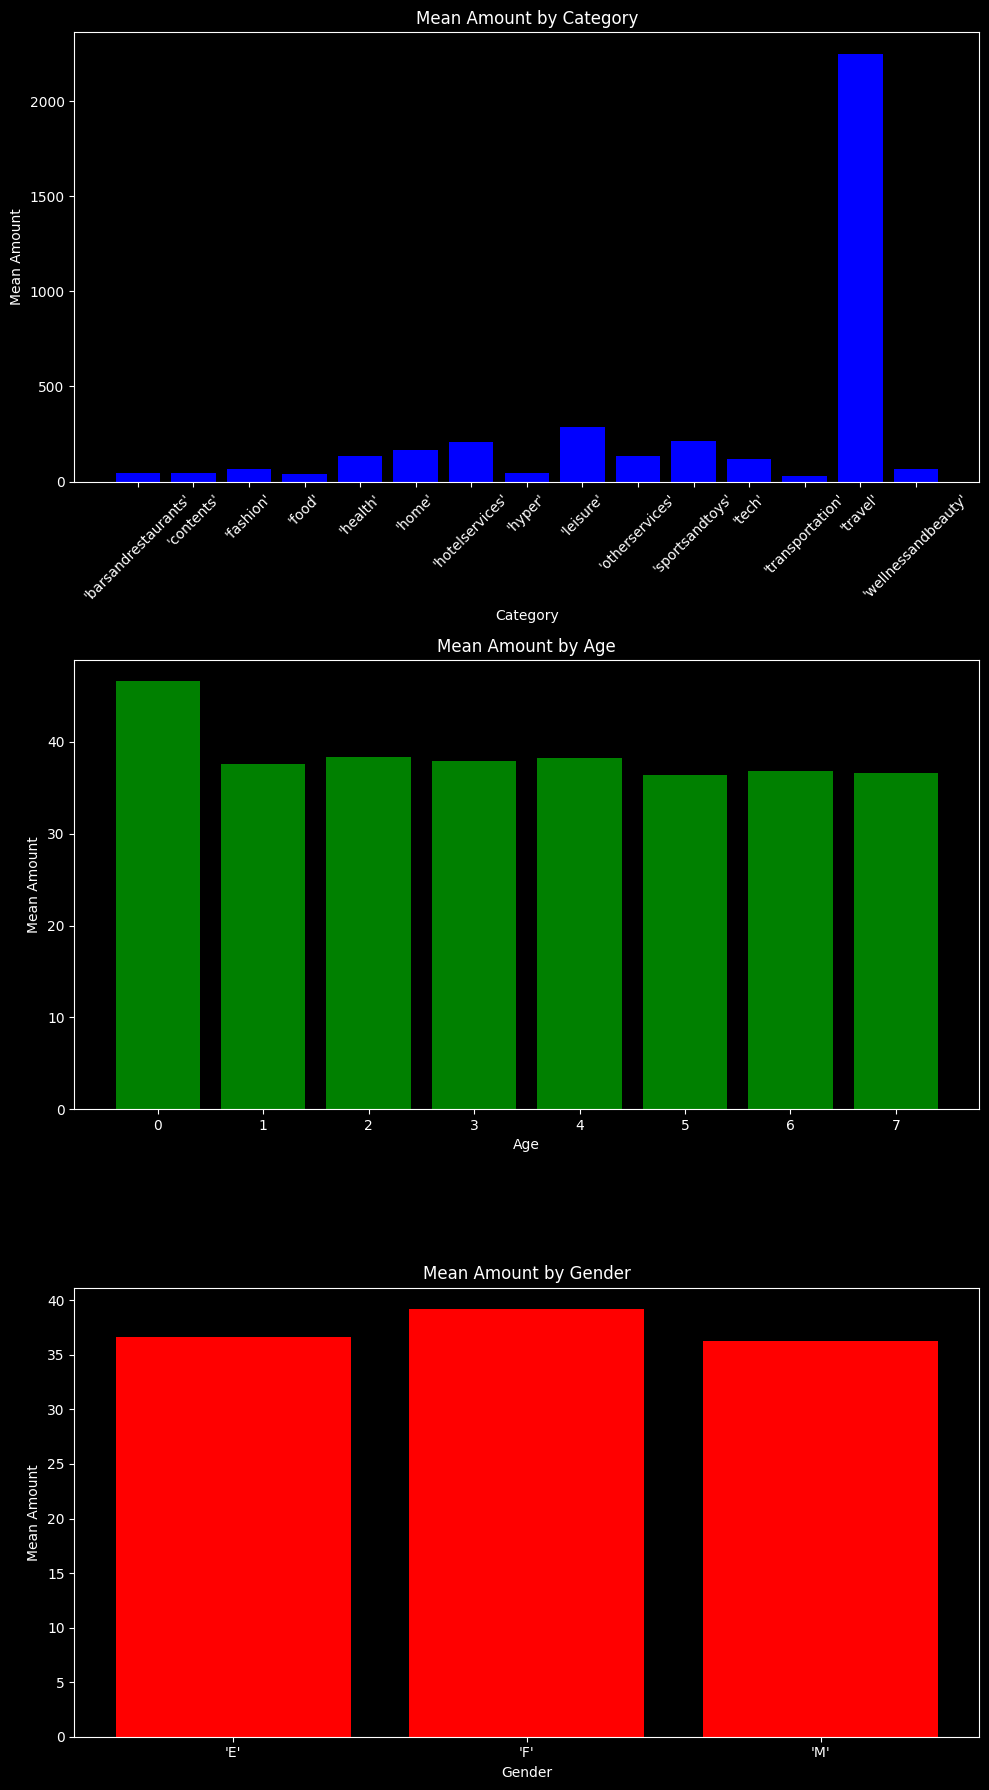

In [10]:
plt.figure(figsize=(10, 18))
plt.subplot(3, 1, 1)
plt.bar(df.groupby('category_original')['amount'].describe().index, df.groupby('category_original')['amount'].describe()['mean'], color='blue')
plt.title('Mean Amount by Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Mean Amount') 
plt.subplot(3, 1, 2)
plt.bar(df.groupby('age')['amount'].describe().index, df.groupby('age')['amount'].describe()['mean'], color='green')
plt.title('Mean Amount by Age')
plt.xlabel('Age')
plt.ylabel('Mean Amount')
plt.subplot(3, 1, 3)
plt.bar(df.groupby('gender_original')['amount'].describe().index, df.groupby('gender_original')['amount'].describe()['mean'], color='red')
plt.title('Mean Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Amount')
plt.tight_layout()
plt.show()


#### Fraud Plots

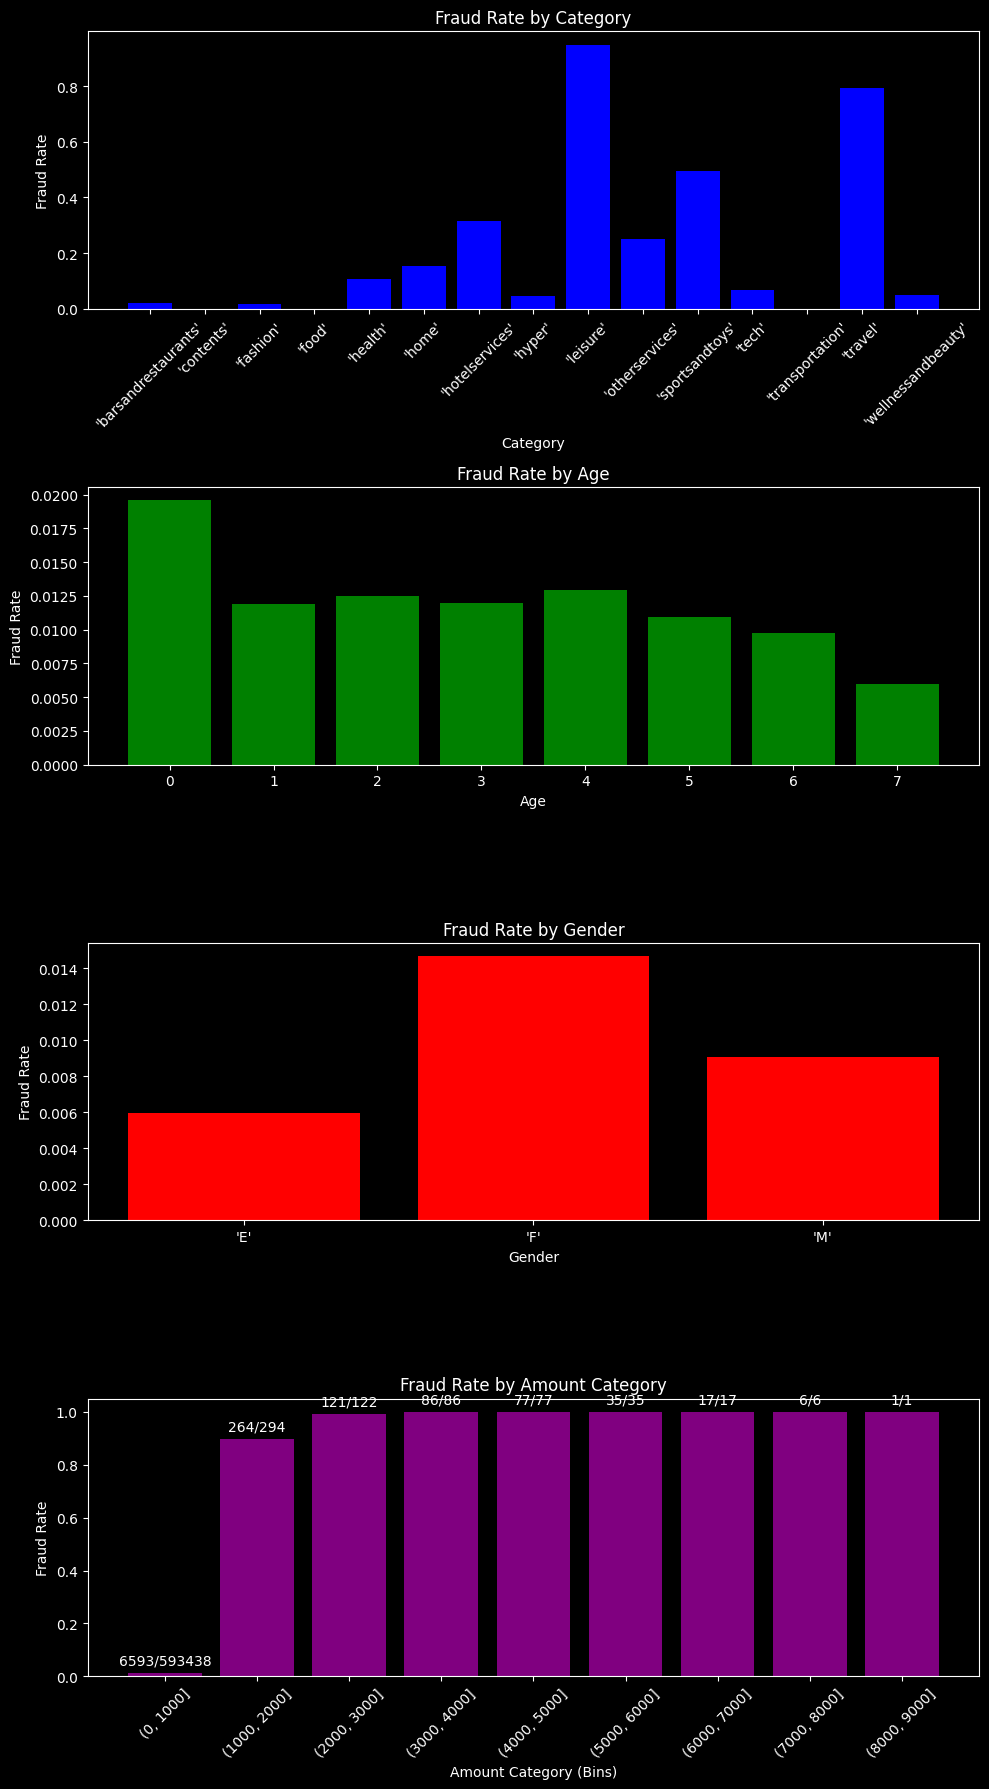

In [11]:
# plot the frauds distribution in corelation with the amount / gender / age / category
plt.figure(figsize=(10, 18))
plt.subplot(4, 1, 1)
plt.bar(df.groupby('category_original')['fraud'].describe().index, df.groupby('category_original')['fraud'].describe()['mean'], color='blue')
plt.title('Fraud Rate by Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 2)
plt.bar(df.groupby('age')['fraud'].describe().index, df.groupby('age')['fraud'].describe()['mean'], color='green')
plt.title('Fraud Rate by Age')
plt.xlabel('Age')
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 3)
plt.bar(df.groupby('gender_original')['fraud'].describe().index, df.groupby('gender_original')['fraud'].describe()['mean'], color='red')
plt.title('Fraud Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 4)

# plot the fraud rate by amount, using bins of 1000

amount_bins = pd.cut(df['amount'], bins=range(0, int(df['amount'].max()) + 1000, 1000))
fraud_rate_by_amount = df.groupby(amount_bins,observed=False)['fraud'].mean()
fraud_counts_by_amount = df.groupby(amount_bins, observed=False)['fraud'].sum()
total_counts_by_amount = df.groupby(amount_bins, observed=False)['fraud'].count()

bars = plt.bar(fraud_rate_by_amount.index.astype(str), fraud_rate_by_amount.values, color='purple')

# Annotate each bar with the count of frauds and total inputs
for bar, bin_label in zip(bars, fraud_rate_by_amount.index):
    height = bar.get_height()
    fraud_count = fraud_counts_by_amount[bin_label]
    total_count = total_counts_by_amount[bin_label]
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f"{fraud_count}/{total_count}",
             ha='center', va='bottom', fontsize=10)
plt.bar(fraud_rate_by_amount.index.astype(str), fraud_rate_by_amount.values, color='purple')
plt.xticks(rotation=45)
plt.title('Fraud Rate by Amount Category')
plt.xlabel('Amount Category (Bins)')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.show()

# 4. Classification

## 4.1. Initial attempt

In [12]:
# Define the features and target variable
X = df.drop(columns=['fraud','gender_original','category_original'])
y = df['fraud']

In [13]:
X = MaxAbsScaler().fit_transform(X.astype(float))

In [14]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
recall_dict = {}
# Check if the file exists
if os.path.exists('results/recall_dict.csv'):
    # Load recall dict from file
    recall_dict = pd.read_csv('results/recall_dict.csv')
    recall_dict = recall_dict.set_index('k').to_dict()['recall']
    recall_dict = {int(k): v for k, v in recall_dict.items()}

In [16]:
if len(recall_dict) == 0:
    # Loop over different values of k
    for k in range(2, 21):
        start_time = time.time()
        # Setup a k-NN Classifier with k neighbors: knn
        knn_clf = KNeighborsClassifier(n_neighbors=k)

        # Fit the classifier to the training data
        knn_clf.fit(X_train, y_train)
        
        #Compute recall on the test set
        recall_dict[k] = recall_score(y_valid, knn_clf.predict(X_valid))
        elapsed_time = time.time() - start_time
        print(f"Recall for k={k}: {recall_dict[k]} Elapsed time: {elapsed_time:.2f} seconds")
        #write the recall dict to file

In [17]:
recall_df = pd.DataFrame(recall_dict.values(), columns=['recall'], index=recall_dict.keys())
recall_df.to_csv('results/recall_dict.csv', index_label='k')
recall_df.sort_values(by='recall', ascending=False)

,recall
3,0.644953
5,0.626342
7,0.617037
9,0.614173
11,0.612742
4,0.600573
13,0.596994
6,0.594846
10,0.594846
8,0.590551


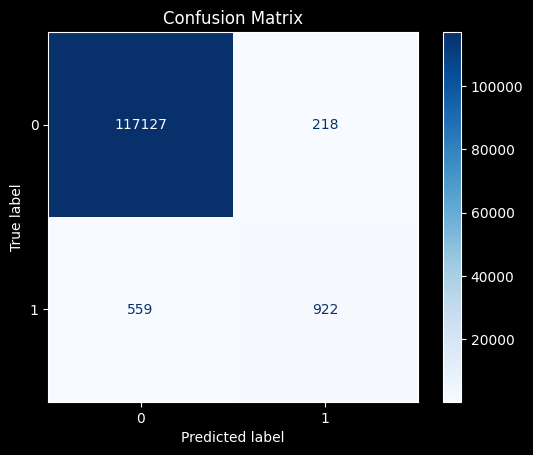

In [18]:
k = 3  # Number of neighbours

# name that we gave to the "algo" instance
neighbours_clf = KNeighborsClassifier(n_neighbors=k)
# Fit the model on the training set
neighbours_clf.fit(X_train, y_train)

#show results on the test set
confMat = confusion_matrix(y_test, neighbours_clf.predict(X_test))
confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=neighbours_clf.classes_)
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [19]:
#print accuracy, precision, recall, f1 score 
print(f"Accuracy: {accuracy_score(y_test, neighbours_clf.predict(X_test)):.2f}")
print(f"Precision: {precision_score(y_test, neighbours_clf.predict(X_test)):.2f}")
print(f"Recall: {recall_score(y_test, neighbours_clf.predict(X_test)):.2f}")
print(f"F1 Score: {f1_score(y_test, neighbours_clf.predict(X_test)):.2f}")

Accuracy: 0.99
Precision: 0.81
Recall: 0.62
F1 Score: 0.70


## 4.2. With PCA

KNN is strongly affected by curse of dimensionality, so we try reducing dimention

In [20]:
# retry with pca
# Create a PCA instance: pca
pca = PCA(n_components=3)
# Fit the PCA instance to the training data
pca.fit(X_train)
# Transform the training data: X_train_pca
X_train_pca = pca.transform(X_train)
# Transform the validation data: X_valid_pca
X_valid_pca = pca.transform(X_valid)
# Transform the test data: X_test_pca
X_test_pca = pca.transform(X_test)


In [21]:
recall_dict_pca = {}
# Check if the file exists
if os.path.exists('results/recall_dict_pca.csv'):
    # Load recall dict from file
    recall_dict_pca = pd.read_csv('results/recall_dict_pca.csv')
    recall_dict_pca = recall_dict_pca.set_index('k').to_dict()['recall']
    recall_dict_pca = {int(k): v for k, v in recall_dict_pca.items()}

In [22]:
if len(recall_dict_pca) == 0:
    # Loop over different values of k
    for k in range(2, 21):
        start_time = time.time()
        # Setup a k-NN Classifier with k neighbors: knn
        knn_clf = KNeighborsClassifier(n_neighbors=k)

        # Fit the classifier to the training data
        knn_clf.fit(X_train_pca, y_train)
        
        #Compute recall on the test set
        recall_dict_pca[k] = recall_score(y_valid, knn_clf.predict(X_valid_pca))
        elapsed_time = time.time() - start_time
        print(f"Recall for k={k}: {recall_dict_pca[k]} Elapsed time: {elapsed_time:.2f} seconds")
        #write the recall dict to file

In [23]:
recall_pca_df = pd.DataFrame(recall_dict_pca.values(), columns=['recall'], index=recall_dict_pca.keys())
recall_pca_df.to_csv('results/recall_dict_pca.csv', index_label='k')
recall_pca_df.sort_values(by='recall', ascending=False)

,recall
3,0.642090
5,0.622047
7,0.612742
9,0.609162
11,0.604868
4,0.597709
6,0.589835
10,0.587688
8,0.585540
13,0.584825


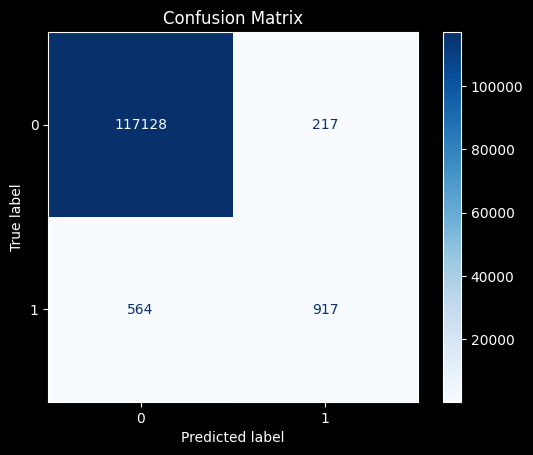

In [24]:
k = 3  # Number of neighbours

# name that we gave to the "algo" instance
neighbours_clf_pca = KNeighborsClassifier(n_neighbors=k)
# Fit the model on the training set
neighbours_clf_pca.fit(X_train_pca, y_train)

#show results on the test set
confMat = confusion_matrix(y_test, neighbours_clf_pca.predict(X_test_pca))
confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=neighbours_clf_pca.classes_)
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [25]:
#print accuracy, precision, recall, f1 score 
print(f"Accuracy: {accuracy_score(y_test, neighbours_clf_pca.predict(X_test_pca)):.2f}")
print(f"Precision: {precision_score(y_test, neighbours_clf_pca.predict(X_test_pca)):.2f}")
print(f"Recall: {recall_score(y_test, neighbours_clf_pca.predict(X_test_pca)):.2f}")
print(f"F1 Score: {f1_score(y_test, neighbours_clf_pca.predict(X_test_pca)):.2f}")

Accuracy: 0.99
Precision: 0.81
Recall: 0.62
F1 Score: 0.70


## 4.3. With Pca & weights based on distance

In [29]:
# Loop over different values of k
for k in range(2, 21):
    start_time = time.time()
    # Setup a k-NN Classifier with k neighbors: knn
    knn_clf = KNeighborsClassifier(n_neighbors=k, weights='distance')

    # Fit the classifier to the training data
    knn_clf.fit(X_train_pca, y_train)
    
    #Compute recall on the test set
    recall_dict_pca[k] = recall_score(y_valid, knn_clf.predict(X_valid_pca))
    f = f1_score(y_valid, knn_clf.predict(X_valid_pca))
    elapsed_time = time.time() - start_time
    print(f"Recall for k={k}: {recall_dict_pca[k]} f1: {f} Elapsed time: {elapsed_time:.2f} seconds")

Recall for k=2: 0.658554044380816 f1: 0.6490299823633157 Elapsed time: 2.33 seconds
Recall for k=3: 0.6521116678596993 f1: 0.6696067622197721 Elapsed time: 2.01 seconds
Recall for k=4: 0.6478167501789549 f1: 0.680195415257422 Elapsed time: 2.00 seconds
Recall for k=5: 0.6399427344309234 f1: 0.6845329249617151 Elapsed time: 2.04 seconds
Recall for k=6: 0.6377952755905512 f1: 0.6877653415669626 Elapsed time: 1.81 seconds
Recall for k=7: 0.635647816750179 f1: 0.6894409937888198 Elapsed time: 1.60 seconds
Recall for k=8: 0.6335003579098067 f1: 0.6946624803767661 Elapsed time: 1.61 seconds
Recall for k=9: 0.6327845382963493 f1: 0.695789059425423 Elapsed time: 1.63 seconds
Recall for k=10: 0.6299212598425197 f1: 0.6945540647198106 Elapsed time: 1.70 seconds
Recall for k=11: 0.6313528990694345 f1: 0.6966824644549763 Elapsed time: 1.77 seconds
Recall for k=12: 0.6277738010021474 f1: 0.6954797779540047 Elapsed time: 1.74 seconds
Recall for k=13: 0.6270579813886901 f1: 0.697174691603661 Elapsed 

In [30]:
pd.DataFrame(recall_dict_pca.values(), columns=['recall'], index=recall_dict_pca.keys()).sort_values(by='recall', ascending=False)

,recall
2,0.658554
3,0.652112
4,0.647817
5,0.639943
6,0.637795
7,0.635648
8,0.633500
9,0.632785
11,0.631353
10,0.629921


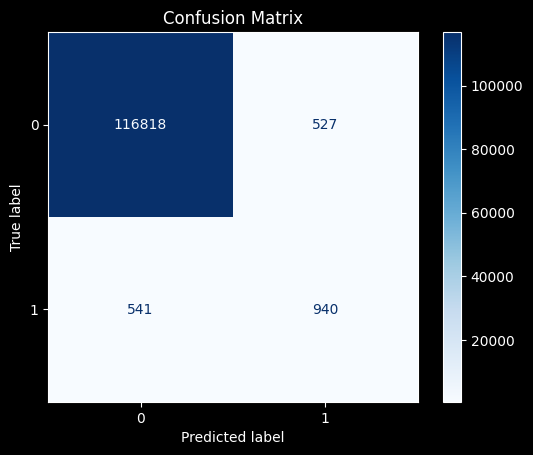

In [31]:
k = 2  # Number of neighbours

# name that we gave to the "algo" instance
neighbours_clf_pca_weighted = KNeighborsClassifier(n_neighbors=k, weights='distance')
# Fit the model on the training set
neighbours_clf_pca_weighted.fit(X_train_pca, y_train)

#show results on the test set
confMat = confusion_matrix(y_test, neighbours_clf_pca_weighted.predict(X_test_pca))
confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=neighbours_clf_pca_weighted.classes_)
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [33]:
#print accuracy, precision, recall, f1 score 
print(f"Accuracy: {accuracy_score(y_test, neighbours_clf_pca_weighted.predict(X_test_pca)):.2f}")
print(f"Precision: {precision_score(y_test, neighbours_clf_pca_weighted.predict(X_test_pca)):.2f}")
print(f"Recall: {recall_score(y_test, neighbours_clf_pca_weighted.predict(X_test_pca)):.2f}")
print(f"F1 Score: {f1_score(y_test, neighbours_clf_pca_weighted.predict(X_test_pca)):.2f}")

Accuracy: 0.99
Precision: 0.64
Recall: 0.63
F1 Score: 0.64
